In [1]:
import os
os.environ["TF_NUM_INTEROP_THREADS"] = "4"
os.environ["TF_NUM_INTRAOP_THREADS"] = "4"
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
import numpy as np

import matplotlib.pyplot as plt
import pandas as pd
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import json
import time

# Check CPU availability
print(f"TensorFlow is running on: {tf.config.list_physical_devices('CPU')}")

# Optimize CPU performance
tf.config.threading.set_inter_op_parallelism_threads(4)
tf.config.threading.set_intra_op_parallelism_threads(4)

TensorFlow is running on: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [2]:
# Cell 2: Set up configuration parameters
# Configuration
IMG_SIZE = 150  # Image size (height, width)
BATCH_SIZE = 16  # Lower batch size to optimize CPU
EPOCHS = 35
CLASSES = ['COVID-19', 'Normal', 'Pneumonia-Bacterial', 'Pneumonia-Viral']

# Directory paths
base_dir = r"C:\Users\Disha\Downloads\Processed Dataset"
train_dir = os.path.join(base_dir, "train")
val_dir = os.path.join(base_dir, "val")
test_dir = os.path.join(base_dir, "test")


In [3]:
# Cell 3: Define data augmentation and preprocessing
# Data augmentation for training
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
    fill_mode='nearest'
)

# Simple preprocessing for validation and test data
val_test_datagen = ImageDataGenerator(rescale=1./255)


In [4]:
# Cell 4: Set up data generators
# Load dataset
train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=True,
    color_mode='grayscale'
)

validation_generator = val_test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    color_mode='grayscale'
)

test_generator = val_test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMG_SIZE, IMG_SIZE),
    batch_size=BATCH_SIZE,
    class_mode='categorical',
    shuffle=False,
    color_mode='grayscale'
)


Found 8644 images belonging to 4 classes.
Found 2152 images belonging to 4 classes.
Found 2176 images belonging to 4 classes.


In [5]:
# Cell 5: Calculate class weights to handle class imbalance
# Calculate class weights to handle imbalance
class_counts = np.bincount(train_generator.classes)
total = sum(class_counts)
class_weights = {i: total / (len(class_counts) * count) for i, count in enumerate(class_counts)}
print("Class weights:", class_weights)


Class weights: {0: 1.7903893951946976, 1: 0.7023074423139422, 2: 0.7654976974849451, 3: 1.4059856864020819}


In [6]:
# Cell 6: Define the CNN model architecture
# Define the CNN model
def build_custom_model():
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(IMG_SIZE, IMG_SIZE, 1)),
        BatchNormalization(),
        Conv2D(32, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.2),

        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(64, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        Conv2D(128, (3, 3), activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling2D((2, 2)),
        Dropout(0.3),

        Flatten(),
        Dense(256, activation='relu'),
        BatchNormalization(),
        Dropout(0.5),
        Dense(len(CLASSES), activation='softmax')
    ])

    model.compile(
        optimizer=Adam(learning_rate=0.0005),
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    return model


In [7]:
# Cell 7: Create and summarize the model
# Create the model
print("Creating custom CNN model...")
model = build_custom_model()
model.summary()


Creating custom CNN model...


C:\Users\Disha\anaconda3\envs\tensorflow-env\lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 150, 150, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 150, 150, 32)   │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 150, 150, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 75, 75, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 75, 75, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 75, 75, 64)     │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 75, 75, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 37, 37, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 37, 37, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 37, 37, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 37, 37, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 18, 18, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 41472)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │    10,617,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼─────────────

 Total params: 10,907,364 (41.61 MB)

 Trainable params: 10,905,956 (41.60 MB)

 Non-trainable params: 1,408 (5.50 KB)

In [8]:
# Cell 8: Set up callbacks for training
# Callbacks for better training
checkpoint = ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True, mode='max', verbose=1)
early_stopping = EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=2, min_lr=1e-6, verbose=1)


In [9]:
# Cell 9: Train the model
# Train model
start_time = time.time()
print("Starting training...")

history = model.fit(
    train_generator,
    validation_data=validation_generator,
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=[checkpoint, early_stopping, reduce_lr]
)

print(f"Training completed in {time.time() - start_time:.2f} seconds")


Starting training...


C:\Users\Disha\anaconda3\envs\tensorflow-env\lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/35
541/541 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5820 - loss: 1.1117
Epoch 1: val_accuracy improved from -inf to 0.40381, saving model to best_model.h5


541/541 ━━━━━━━━━━━━━━━━━━━━ 891s 2s/step - accuracy: 0.5821 - loss: 1.1113 - val_accuracy: 0.4038 - val_loss: 2.3492 - learning_rate: 5.0000e-04
Epoch 2/35
541/541 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7010 - loss: 0.7195
Epoch 2: val_accuracy improved from 0.40381 to 0.78067, saving model to best_model.h5


541/541 ━━━━━━━━━━━━━━━━━━━━ 820s 2s/step - accuracy: 0.7010 - loss: 0.7195 - val_accuracy: 0.7807 - val_loss: 0.5330 - learning_rate: 5.0000e-04
Epoch 3/35
541/541 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7121 - loss: 0.6561
Epoch 3: val_accuracy did not improve from 0.78067
541/541 ━━━━━━━━━━━━━━━━━━━━ 820s 2s/step - accuracy: 0.7121 - loss: 0.6561 - val_accuracy: 0.6696 - val_loss: 0.9184 - learning_rate: 5.0000e-04
Epoch 4/35
541/541 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7157 - loss: 0.6572
Epoch 4: val_accuracy improved from 0.78067 to 0.80901, saving model to best_model.h5


541/541 ━━━━━━━━━━━━━━━━━━━━ 826s 2s/step - accuracy: 0.7157 - loss: 0.6572 - val_accuracy: 0.8090 - val_loss: 0.4853 - learning_rate: 5.0000e-04
Epoch 5/35
541/541 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7453 - loss: 0.6054
Epoch 5: val_accuracy did not improve from 0.80901
541/541 ━━━━━━━━━━━━━━━━━━━━ 923s 2s/step - accuracy: 0.7453 - loss: 0.6054 - val_accuracy: 0.8053 - val_loss: 0.4809 - learning_rate: 5.0000e-04
Epoch 6/35
541/541 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7422 - loss: 0.6051
Epoch 6: val_accuracy did not improve from 0.80901

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0002500000118743628.
541/541 ━━━━━━━━━━━━━━━━━━━━ 865s 2s/step - accuracy: 0.7421 - loss: 0.6051 - val_accuracy: 0.5623 - val_loss: 1.3267 - learning_rate: 5.0000e-04
Epoch 7/35
541/541 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7412 - loss: 0.6266
Epoch 7: val_accuracy did not improve from 0.80901
541/541 ━━━━━━━━━━━━━━━━━━━━ 839s 2s/step - accuracy: 0.7413 - loss: 0.6265 -

541/541 ━━━━━━━━━━━━━━━━━━━━ 811s 1s/step - accuracy: 0.7501 - loss: 0.5791 - val_accuracy: 0.8169 - val_loss: 0.5021 - learning_rate: 2.5000e-04
Epoch 9/35
541/541 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7542 - loss: 0.5940
Epoch 9: val_accuracy did not improve from 0.81691
541/541 ━━━━━━━━━━━━━━━━━━━━ 810s 1s/step - accuracy: 0.7542 - loss: 0.5940 - val_accuracy: 0.7653 - val_loss: 0.5671 - learning_rate: 2.5000e-04
Epoch 10/35
541/541 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7609 - loss: 0.5638
Epoch 10: val_accuracy did not improve from 0.81691

Epoch 10: ReduceLROnPlateau reducing learning rate to 0.0001250000059371814.
541/541 ━━━━━━━━━━━━━━━━━━━━ 853s 2s/step - accuracy: 0.7609 - loss: 0.5638 - val_accuracy: 0.8146 - val_loss: 0.4563 - learning_rate: 2.5000e-04
Epoch 11/35
541/541 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7756 - loss: 0.5373
Epoch 11: val_accuracy improved from 0.81691 to 0.82063, saving model to best_model.h5


541/541 ━━━━━━━━━━━━━━━━━━━━ 839s 2s/step - accuracy: 0.7756 - loss: 0.5372 - val_accuracy: 0.8206 - val_loss: 0.4207 - learning_rate: 1.2500e-04
Epoch 12/35
541/541 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7609 - loss: 0.5430
Epoch 12: val_accuracy improved from 0.82063 to 0.82203, saving model to best_model.h5


541/541 ━━━━━━━━━━━━━━━━━━━━ 896s 2s/step - accuracy: 0.7609 - loss: 0.5430 - val_accuracy: 0.8220 - val_loss: 0.4092 - learning_rate: 1.2500e-04
Epoch 13/35
541/541 ━━━━━━━━━━━━━━━━━━━━ 0s 3s/step - accuracy: 0.7826 - loss: 0.5245
Epoch 13: val_accuracy improved from 0.82203 to 0.82946, saving model to best_model.h5


541/541 ━━━━━━━━━━━━━━━━━━━━ 1796s 3s/step - accuracy: 0.7826 - loss: 0.5245 - val_accuracy: 0.8295 - val_loss: 0.4174 - learning_rate: 1.2500e-04
Epoch 14/35
541/541 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.7845 - loss: 0.5068
Epoch 14: val_accuracy did not improve from 0.82946
541/541 ━━━━━━━━━━━━━━━━━━━━ 955s 2s/step - accuracy: 0.7845 - loss: 0.5068 - val_accuracy: 0.8072 - val_loss: 0.4918 - learning_rate: 1.2500e-04
Epoch 15/35
541/541 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7839 - loss: 0.4957
Epoch 15: val_accuracy did not improve from 0.82946

Epoch 15: ReduceLROnPlateau reducing learning rate to 6.25000029685907e-05.
541/541 ━━━━━━━━━━━━━━━━━━━━ 817s 2s/step - accuracy: 0.7839 - loss: 0.4957 - val_accuracy: 0.6492 - val_loss: 1.3651 - learning_rate: 1.2500e-04
Epoch 16/35
541/541 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7835 - loss: 0.5126
Epoch 16: val_accuracy improved from 0.82946 to 0.83968, saving model to best_model.h5


541/541 ━━━━━━━━━━━━━━━━━━━━ 875s 2s/step - accuracy: 0.7835 - loss: 0.5126 - val_accuracy: 0.8397 - val_loss: 0.3969 - learning_rate: 6.2500e-05
Epoch 17/35
541/541 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7902 - loss: 0.4928
Epoch 17: val_accuracy did not improve from 0.83968
541/541 ━━━━━━━━━━━━━━━━━━━━ 844s 2s/step - accuracy: 0.7902 - loss: 0.4928 - val_accuracy: 0.8327 - val_loss: 0.3984 - learning_rate: 6.2500e-05
Epoch 18/35
541/541 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7947 - loss: 0.4814
Epoch 18: val_accuracy did not improve from 0.83968

Epoch 18: ReduceLROnPlateau reducing learning rate to 3.125000148429535e-05.
541/541 ━━━━━━━━━━━━━━━━━━━━ 820s 2s/step - accuracy: 0.7948 - loss: 0.4814 - val_accuracy: 0.8299 - val_loss: 0.4086 - learning_rate: 6.2500e-05
Epoch 19/35
541/541 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.7879 - loss: 0.4919
Epoch 19: val_accuracy did not improve from 0.83968
541/541 ━━━━━━━━━━━━━━━━━━━━ 874s 2s/step - accuracy: 0.7879 - loss: 0

In [10]:
# Cell 10: Load the best model
# Load best model
from tensorflow.keras.models import load_model
print("Loading best model...")
best_model = load_model('best_model.h5')


Loading best model...


In [17]:
# Cell 11: Evaluate the model
import io
import sys
import re
from contextlib import redirect_stdout

# Evaluate model and capture detailed metrics
print("Evaluating model on test data...")
captured_output = io.StringIO()
with redirect_stdout(captured_output):
    # Run standard evaluation
    test_loss, test_accuracy = best_model.evaluate(test_generator, steps=len(test_generator))

# Display the full evaluation output
output_text = captured_output.getvalue()
print(output_text, end="")

# Extract the batch-level accuracy for reporting
progress_matches = re.findall(r'accuracy: (0\.\d+)', output_text)
if progress_matches:
    batch_accuracy = float(progress_matches[-1])
    print(f"Model accuracy: {batch_accuracy * 100:.2f}%")
else:
    # If batch metrics aren't available, use overall accuracy
    print(f"Model accuracy: {test_accuracy * 100:.2f}%")

Evaluating model on test data...
136/136 ━━━━━━━━━━━━━━━━━━━━ 41s 302ms/step - accuracy: 0.9364 - loss: 0.1952
Model accuracy: 93.64%


In [18]:
# Cell 12: Generate predictions and classification report
# Predictions and classification report
print("Generating predictions...")
test_generator.reset()
y_pred_prob = best_model.predict(test_generator, steps=len(test_generator))
y_pred = np.argmax(y_pred_prob, axis=1)

# Get actual labels
y_true = test_generator.classes[:len(y_pred)]

# Print classification report
print("\nClassification Report:")
report = classification_report(y_true, y_pred, target_names=CLASSES, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df)


Generating predictions...
136/136 ━━━━━━━━━━━━━━━━━━━━ 47s 344ms/step

Classification Report:
                     precision    recall  f1-score      support
COVID-19              0.934375  0.983553  0.958333   304.000000
Normal                0.912281  0.950392  0.930946   766.000000
Pneumonia-Bacterial   0.784123  0.787413  0.785764   715.000000
Pneumonia-Viral       0.608824  0.529412  0.566347   391.000000
accuracy              0.825827  0.825827  0.825827     0.825827
macro avg             0.809900  0.812692  0.810348  2176.000000
weighted avg          0.818729  0.825827  0.821554  2176.000000


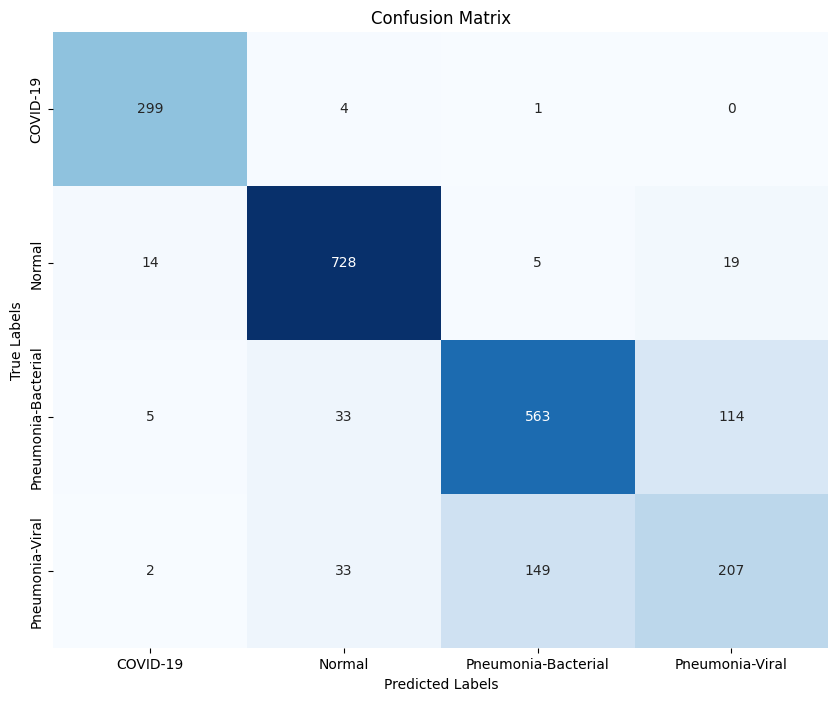

In [19]:
# Cell 13: Create and save confusion matrix
# Confusion matrix
cm = confusion_matrix(y_true, y_pred)
cm_df = pd.DataFrame(cm, index=CLASSES, columns=CLASSES)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm_df, annot=True, fmt='d', cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.savefig('confusion_matrix.png')


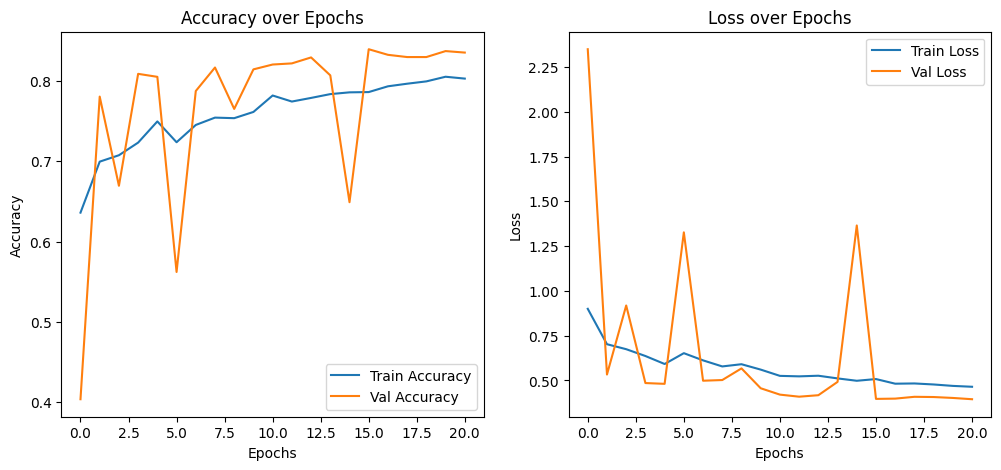

In [20]:
# Cell 14: Plot and save training history
# Plot training history
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.savefig('training_history.png')


In [21]:
# Cell 15: Save the best model for Streamlit
best_model.save('best_model.h5')

print("✅ Best model saved successfully for Streamlit app!")


✅ Best model saved successfully for Streamlit app!


In [22]:
# Cell 15: Save model and class labels for Streamlit
# Save the model for Streamlit
best_model.save('best_model.h5')

with open('class_labels.json', 'w') as f:
    json.dump(CLASSES, f)

print("✅ Model and class labels saved successfully for Streamlit app!")


✅ Model and class labels saved successfully for Streamlit app!
